In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import psycopg2

In [38]:
#Connect to the Retail Database in my postgress

dbconn = psycopg2.connect("dbname=saledata user=doctaa password=pass!")


In [39]:
#Open Cursor to interact with Retail Database

cur = dbconn.cursor()

In [103]:
# To Reset the cursor
cur.execute("ROLLBACK")
dbconn.commit()

#### sql command for the selction and ploting a simple trend. This trend select one kind of business and plots it over the years. grouping the sales of the business by year. 

In [74]:
#step3: execute a sql command with the cursor


sql = "SELECT date_part('year',sales_month) as Sales_year, sum(sales) as Sales\
             FROM \"Retaildata\".retail_sales \
             WHERE kind_of_business = 'Retail and food services sales, total'\
             GROUP BY 1 ORDER BY 1"

cur.execute(sql)

#step 4: save results in a variable
results = cur.fetchall()

In [76]:
df = pd.DataFrame(results)

In [88]:
df.columns = ['Sales Year', 'Sales']

<function matplotlib.pyplot.show(close=None, block=None)>

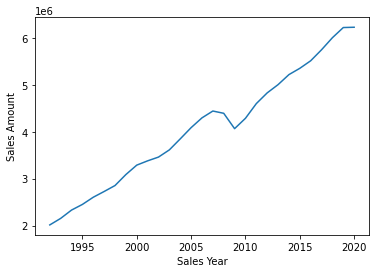

In [95]:
x = df['Sales Year']
y = df['Sales']
pp.plot(x,y)
pp.xlabel('Sales Year')
pp.ylabel('Sales Amount')
pp.show

#### Comparing different components. This query selects and plots different business kinds of sales over the years

In [180]:
sql2 = "SELECT date_part('year',sales_month) as Sales_year,\
                kind_of_business,\
                sum(sales) as Sales\
             FROM \"Retaildata\".retail_sales \
             WHERE kind_of_business in ('Book stores','Sporting goods stores','Hobby, toy, and game stores')\
             GROUP BY 1,2 ORDER BY 1,2"
cur.execute(sql2)
query2 = cur.fetchall()

In [110]:
#component Comparison
compdf = pd.DataFrame(query2)

In [111]:
compdf.columns = ['Year', 'Business Kind', 'Sales']

In [112]:
compdf

,Year,Business Kind,Sales
0,1992.0,Book stores,8327
1,1992.0,"Hobby, toy, and game stores",11251
2,1992.0,Sporting goods stores,15583
3,1993.0,Book stores,9108
4,1993.0,"Hobby, toy, and game stores",11651
...,...,...,...
82,2019.0,"Hobby, toy, and game stores",16261
83,2019.0,Sporting goods stores,43808
84,2020.0,Book stores,6425
85,2020.0,"Hobby, toy, and game stores",17287


In [122]:
## Breaking the data frame down into our three components to be plotted
book_store_df = compdf[compdf['Business Kind'].str.contains('Book stores')]
sporting_goods_stores = compdf[compdf['Business Kind'].str.contains('Sporting goods stores')]
hobby_toy_game = compdf[compdf['Business Kind'].str.contains('Hobby, toy, and game stores')]

In [225]:
#setting our component y axis elements. 

y1 = compdf[compdf['Business Kind']== 'Book stores']['Sales']
y2 = compdf[compdf['Business Kind']== 'Sporting goods stores']['Sales']
y3 = compdf[compdf['Business Kind']== 'Hobby, toy, and game stores']['Sales']
x = sporting_goods_stores['Year']


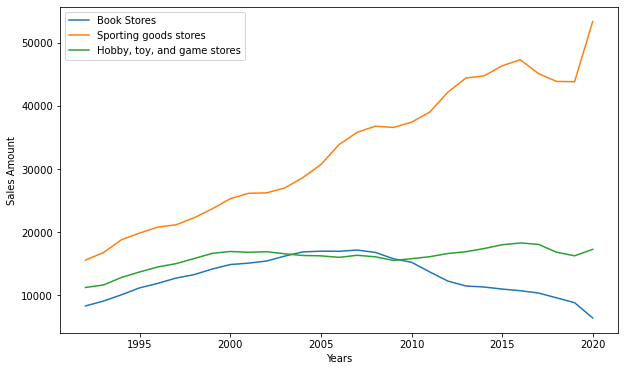

In [168]:
#Plotting our 3 components on the same figure. using secondary_y parameter

fig, ax = pp.subplots(figsize=(10,6))

ax.plot(x, y1, label='Book Stores'),
ax.plot(x, y2, label='Sporting goods stores'),
ax.plot(x, y3, label='Hobby, toy, and game stores')

#labels

ax.set_xlabel('Years')
ax.set_ylabel('Sales Amount')
ax.legend()




### “Monthly trend of sales at women’s and men’s clothing stores”

In [244]:
#writing the query to select our data

sql3="select sales_month, kind_of_business, sales from \"Retaildata\".retail_sales where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')"

#executing the query
cur.execute(sql3)

#Saving the query result
query3 = cur.fetchall()

In [202]:
clothingdf = pd.DataFrame(query3)

In [204]:
clothingdf.columns=['Year', 'Clothing Stores', 'Sales']

In [235]:
#Preparing the Data for Plotting
#the code below creates our coordinates for plotting the data.

x1 = clothingdf[clothingdf['Clothing Stores']=="Men's clothing stores"]['Year']
x2 = clothingdf[clothingdf['Clothing Stores']=="Women's clothing stores"]['Year']
z1 = clothingdf[clothingdf['Clothing Stores']=="Men's clothing stores"]['Sales']
z2 = clothingdf[clothingdf['Clothing Stores']=="Women's clothing stores"]['Sales']


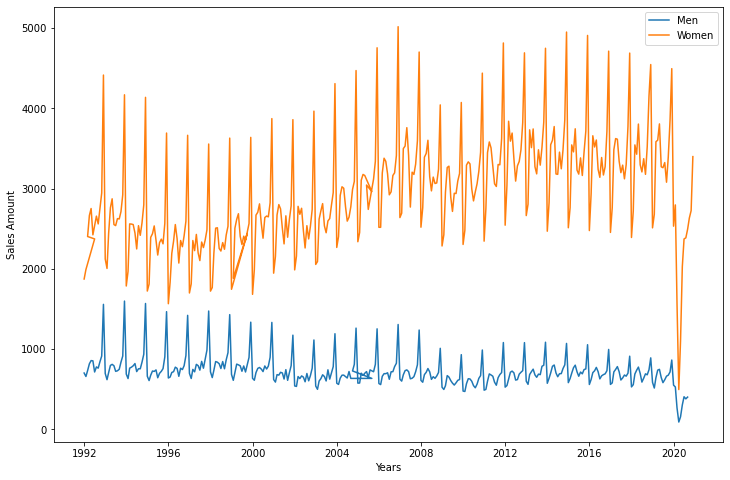

In [239]:
#Plotting of the data

fig, zx = pp.subplots(figsize = (12,8))

zx.plot(x1, z1,label='Men')
zx.plot(x2, z2, label='Women')

zx.set_xlabel('Years')
zx.set_ylabel('Sales Amount')

pp.legend()


# Indexing to Find Percent Change over Time

In [301]:
sql4="SELECT sales_year, kind_of_business, sales\
,first_value(sales) over (PARTITION BY kind_of_business order by sales_year) as index_sales \
FROM\
(\
    SELECT date_part('year',sales_month) as sales_year, kind_of_business\
    ,sum(sales) as sales\
    FROM \"Retaildata\".retail_sales\
    WHERE kind_of_business in ('Women''s clothing stores','Men''s clothing stores') and sales_month <= '2019-12-31'\
    GROUP BY 1,2\
) a"

#sql4 = "select sales_month from \"Retaildata\".retail_sales Limit 5"
cur.execute(sql4)

query4 = cur.fetchall()
indexdf = pd.DataFrame(query4)
indexdf.columns = ['Year','Kind of Business','Sales', 'Index']

In [303]:
indexdf['Change PCT'] = ((indexdf['Sales']-indexdf['Index'])/indexdf['Index'])*100

In [304]:
indexdf['Change PCT']=indexdf['Change PCT']

In [305]:
#plotting the percentage change in both male and female clothing store sales over time. 

#Lets define the coordinates First:
xx1 = indexdf[indexdf['Kind of Business']=="Men's clothing stores"]['Year']
xx2 = indexdf[indexdf['Kind of Business']=="Women's clothing stores"]['Year']
yy1 = indexdf[indexdf['Kind of Business']=="Men's clothing stores"]['Change PCT']
yy2 = indexdf[indexdf['Kind of Business']=="Women's clothing stores"]['Change PCT']


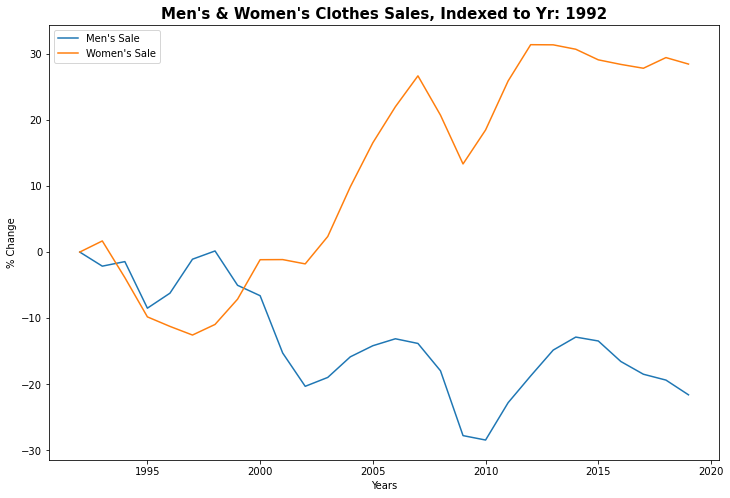

In [336]:
fig, xy = pp.subplots(figsize=(12,8))

xy.plot(xx1, yy1, label="Men's Sale")
xy.plot(xx2, yy2, label="Women's Sale")

xy.set_xlabel('Years')
xy.set_ylabel('% Change')
xy.set_title("Men's & Women's Clothes Sales, Indexed to Yr: 1992", fontsize=15, color='Black', fontweight=550)

xy.legend()

# Rolling Time Window Analysis

In [339]:
sql5 = 'SELECT a.sales_month\
,a.sale\
,b.sales_month as rolling_sales_month\
,b.sales as rolling_sales\
FROM \"Retaildata\".retail_sales a\
JOIN \"Retaildata\".retail_sales b on a.kind_of_business = b.kind_of_business\ 
 and b.sales_month between a.sales_month - interval "11 months"\ 
 and a.sales_month\
 and b.kind_of_business = "Women''s clothing stores\"\
WHERE a.kind_of_business = \"Women''s clothing stores\"
and a.sales_month = \"2019-12-01\"'

SyntaxError: EOL while scanning string literal (1804918207.py, line 6)

In [394]:
sql6 = "SELECT  a.sales_month,\
                a.sales,\
                b.sales_month as rolling_sales_month,\
                b.sales as rolling_sales\
        FROM \"Retaildata\".retail_sales a\
        JOIN \"Retaildata\".retail_sales b on a.kind_of_business = b.kind_of_business\
            and b.sales_month between a.sales_month - interval \'11 months\' \
            and a.sales_month\
            and b.kind_of_business = 'Women''s clothing stores'\
        WHERE a.kind_of_business = 'Women''s clothing stores'\
            and a.sales_month = '2019-12-01'"
            

            

In [395]:
cur.execute('rollback')
cur.execute(sql6)
rolldf = pd.DataFrame(cur.fetchall())
rolldf.columns=['sales_month',  'sales',  'rolling_sales_month',  'rolling_sales']

In [396]:
rolldf

,sales_month,sales,rolling_sales_month,rolling_sales
0,2019-12-01,4496,2019-01-01,2511
1,2019-12-01,4496,2019-02-01,2680
2,2019-12-01,4496,2019-03-01,3585
3,2019-12-01,4496,2019-04-01,3604
4,2019-12-01,4496,2019-05-01,3807
5,2019-12-01,4496,2019-06-01,3272
6,2019-12-01,4496,2019-07-01,3261
7,2019-12-01,4496,2019-08-01,3325
8,2019-12-01,4496,2019-09-01,3080
9,2019-12-01,4496,2019-10-01,3390


True